In this notebook, I followed the below blogpage until the implementation of the model: 

I had to add one additional dimension to the images for 'batch' that SegFormer model needs. That is why matplotlib functions will give an error (just skip for now). The ultimate error is for the last cell. This error occurs because the proj layer expects the input tensor to have a shape with the last dimension (axis -1) equal to 3, but the input shape received by the proj layer is (1, 134, 9, 128).

The issue seems to be related to the data preprocessing or input configuration for your model. To fix this, you should check the following:

Verify that the images in your dataset have the correct shape (height, width, channels). In this case, the channels should be 3, as it represents the RGB color channels.
Check the data preprocessing pipeline for your images. Ensure that the images are being loaded and resized correctly to the expected input shape of the model.
Verify the configuration of the proj layer or any other layer in your segformer model that might expect a specific input shape. Make sure the input shape is compatible with the model architecture.
Ensure that the input images are correctly passed to the model during training and validation.



https://www.analyticsvidhya.com/blog/2023/04/deep-learning-for-image-segmentation-with-tensorflow/

Some cells used: 
https://keras.io/examples/vision/segformer/

## our model:

### approach1: stepwise --> segmentation + classification (separate notebooks, both using segformer) 
### --> inputs: preimage + binary_mask, postimage + damage_mask

### approach2: one4all --> both problems at the same time (one notebook using segformer) 
### --> input: one image of merged channels (red with red, green wwith green..., normalize in the range (0,255)) coming from pre and post images (1024,1024,3)  

## Important notebooks so far:

### 1. stepwise_model_segmentation.ipynb
### 2. stepwise_model_classification.ipynb
### 3. one4all_model_segmentation_classification.ipynb

### 4. EDA.ipynb ---> it was called jsonconverter_g.ipynb
### 5. plot_mask_segmentation.ipynb
### 6. plot_mask_classification.ipynb

### delete from the repo:
### 1. masking_g.ipynb

### rename in repo:
### masking_building_plus_damage.ipynb ---> to 6
### model_running.ipynb --> stepwise_model_template.ipynb

## Notebooks needed to run this notebook:

### 1. get_tensors_pre_post.ipynb
### 2. 

In [1]:
import os
#import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [2]:
from PIL import Image
import numpy as np

def read_png_image(file_path):
    image = Image.open(file_path)
    image_array = np.array(image)
    return image_array

In [ ]:
# TO DO: in the script that creates the masks, instead of creating the images, change to create arrays and save them in npz format

# Convert lists to numpy arrays
#images = np.stack(image_arrays)
#masks = np.stack(mask_arrays)

#print(images.shape)
#print(masks.shape)

# saving the arrays in npz numpy format 
#np.savez('input_model.npz', images=images, masks=masks)

In [ ]:
# to recover arrays:
# #to recover images and mask arrays:
#loaded_arrays = np.load('input_model.npz')
#images = loaded_arrays['images']
#masks = loaded_arrays['masks']
## to see the pixel values of only mask number 5
#print(masks[5, :, :, 0])
# see the values that fill the mask number 5 
#print(np.unique(masks[9, :, :, 0])) # [0 1 4] --> only buildings with damage levels 1 and 4 in this

In [3]:

def convert_mask_to_single_channel(mask_3_channels):
    """convert 3 channel mask (numpy array) in 1 channel mask, preserving labels 
    defined in "category_colors" dictionary
    
    Args:
        mask (~numpy.ndarray): A mask array to be transformed. This is in
            RGB format.
        
    Returns:
        mask (~numpy.ndarray) with one channel.
    """
    # Assuming mask_3_channels has shape (height, width, 3)
    height, width, _ = mask_3_channels.shape

    # Create an empty array with shape (height, width, 1) for the single-channel mask
    single_channel_mask = np.zeros((height, width, 1), dtype=np.uint8)

    # Define the colors representing each category (RGB values)
    category_colors = {
        (0, 0, 0): 0,        # Class 0 - Black (no building) or un-classified
        (255, 255, 255): 1,  # Class 1 - White (no-damage)
        (255, 0, 0): 2,      # Class 2 - Red (minor damage)
        (0, 255, 0): 3,      # Class 3 - Green (major damage)
        (0, 0, 255): 4,      # Class 4 - Blue (destroyed)
    }
    # Loop through each pixel and assign the corresponding category to the single-channel mask
    for y in range(height):
        for x in range(width):
            pixel_color = tuple(mask_3_channels[y, x])
            category = category_colors.get(pixel_color, -1)  # -1 for unknown category
            single_channel_mask[y, x] = category

    return single_channel_mask

In [54]:
# in this cell we were trying to play with the masks, add them and divide by 2, but it didn't work

# we don't need this cell anymore because we made a notebook to create pre and post arrays
# from images annd masks. They are saved in npz files. npz files include as well information
# about the name of the file and disaster name and type

# this cell uses png mask images and convert them to 1 channel
# That's why we don't use this cell anymore, because it needs to create a tensor from a png image
from os import path, walk, makedirs
from tqdm import tqdm

path_example="/Users/gmeneses/DScourse/00_capstone/xView2_baseline_fork/xBD_last_subset_test_mask"
disasters = next(walk(path_example))[1]

image_arrays = []
mask_arrays = []
im1 = []
im2 = []
for disaster in disasters:
    #print(disaster+':\n')
    # Create the full path to the images, labels, and mask output directories
    image_dir = path.join(path_example, disaster, 'images')
    mask_dir = path.join(path_example, disaster, 'masks')

    if not path.isdir(image_dir):
        print(
            "Error, could not find image files in {}.\n\n"
            .format(image_dir),
            file=stderr)
        exit(2)

    if not path.isdir(mask_dir):
        print(
            "Error, could not find labels in {}.\n\n"
            .format(mask_dir),
            file=stderr)
        exit(3)
    
        
    # running through masks because it can be that there are no masks for certain images (images with empty features)
    # attention: in this case masks have the same name than images
    masks_list = [j for j in next(walk(mask_dir))[2] if '_post' in j]

    for im in tqdm(masks_list, desc='Creating image and mask arrays for '+disaster, unit='im'):
        img_pre_name = path.splitext(im.replace('_post', '_pre'))[0] + '.png'
        img_post_name = im
        mask_name = im
        # path to images and mask
        img_pre_path = path.join(image_dir,img_pre_name)
        img_post_path = path.join(image_dir,img_post_name)
        mask = path.join(mask_dir,mask_name)
        # creating tensors from images
        img_pre = tf.io.read_file(img_pre_path)
        img_post = tf.io.read_file(img_post_path)

        array_pre = tf.image.decode_png(img_pre, channels=3, dtype=tf.uint8)
        array_post = tf.image.decode_png(img_post, channels=3, dtype=tf.uint8)
        # creating a final image array (1024x1024x6) --> this approach does not work with this model
        #array_image = tf.concat([array_pre, array_post], axis=2)
        array_image_plus = tf.math.add(array_pre,array_post)
        array_image = tf.math.floordiv(array_image_plus, 2, name=None)
        # processing the mask
        array_mask_3d = read_png_image(mask)
        # converting mask to depth 1
        array_mask = convert_mask_to_single_channel(array_mask_3d)
         
        
        # adding to lists in array format
        image_arrays.append(array_image)
        mask_arrays.append(tf.convert_to_tensor(array_mask))
        im1.append(array_pre)
        im2.append(array_post)



        

Creating image and mask arrays for guatemala-volcano:   0%|          | 0/12 [00:00<?, ?im/s]

Creating image and mask arrays for guatemala-volcano: 100%|██████████| 12/12 [00:37<00:00,  3.12s/im]


In [55]:
# print(type(image_arrays))
# # to see the pixel values of only mask number 5
# one_image=image_arrays[5][:, :, :]
# one_image_pre = im1[5][:, :, :]
# one_image_post = im2[5][:, :, :]

# print(one_image.shape)
# #see the values that fill the mask number 5 
# print(np.unique(one_image)) # [0 1 4] --> only buildings with damage levels 1 and 4 in this
# print(np.unique(one_image_pre))
# print(np.unique(one_image_post))
# print(type(one_image_pre))

<class 'list'>
(1024, 1024, 3)
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127]
[  0   3   4   5   7   8   9  10  11  12  13  14  15  16  17  18  19  20
  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38
  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56
  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74
  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92
  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110
 111 112 1

In [ ]:
# old way to access data

# # A list to collect paths of 1000 images
# image_path = []
# for root, dirs, files in os.walk('/Users/gmeneses/DScourse/00_capstone/xView2_baseline_fork/xBD_last_subset_test_mask/guatemala-volcano/images'):
#     # Iterate over 1000 images
#     for file in files:
#         # Check if the file has a PNG extension
#         if file.lower().endswith('.png') and '_post' in file:
#             # Create path
#             path = os.path.join(root, file)
#             # Add path to list
#             image_path.append(path)
            
# print(len(image_path))

# # A list to collect paths of 1000 masks
# mask_path = []
# for root, dirs, files in os.walk('/Users/gmeneses/DScourse/00_capstone/xView2_baseline_fork/xBD_last_subset_test_mask/guatemala-volcano/masks'):
#     # Iterate over 1000 masks
#     for file in files:
#         # Check if the file has a PNG extension
#         if file.lower().endswith('.png'):
#             # Obtain the path
#             path = os.path.join(root, file)
#             # Add path to the list
#             mask_path.append(path)
# print(len(mask_path))

     

12
12


In [ ]:
# old way to deal with the images and create the tensors

# from PIL import Image
# # create a list to store images
# images = []
# # iterate over 1000 image paths
# for path in tqdm(image_path):
#     # read file
#     file = tf.io.read_file(path)
#     # decode png file into a tensor
#     image = tf.image.decode_png(file, channels=3, dtype=tf.uint8)

#     # #adding 4th dimension for batch size 
#     # image = tf.expand_dims(image, axis=0)
#     # append to the list
#     images.append(image)


# # create a list to store masks
# masks = []
# # iterate over 1000 mask paths
# for path in tqdm(mask_path):
#     print(path)
#     # read the file
#     #file = tf.io.read_file(path)
#     file = Image.open(path)
#     mask_3_channels = np.array(file)
#     # decode png file into a tensor
#     #mask_3_channels = tf.image.decode_png(file, channels=3, dtype=tf.uint8)
#     mask = convert_mask_to_single_channel(mask_3_channels)
#     print(np.unique(mask[:, :, 0]))
#     # #adding 4th dimension for batch size 
#     # mask = tf.expand_dims(mask, axis=0)
#     # append mask to the list
#     masks.append(tf.convert_to_tensor(mask))

In [ ]:
# plt.figure(figsize=(25,13))

# # Iterate over the images in the range 4-6
# for i in range(4,7):
#     # Create a subplot for each image
#     plt.subplot(4,6,i)
#     # Get the i-th image from the list
#     img = images[i]
#     # Show the image with a colorbar
#     plt.imshow(img)
#     plt.colorbar()
#     # Turn off the axis labels
#     plt.axis('off')

# # Display the figure
# plt.show()

In [ ]:
# # Define a normalizer that can be applied while visualizing masks to have a consistency
# NORM = mpl.colors.Normalize(vmin=0, vmax=58)

# # plot masks
# plt.figure(figsize=(25,13))
# for i in range(4,7):
#     plt.subplot(4,6,i)
#     img = masks[i]
#     plt.imshow(img, cmap='jet', norm=NORM)
#     plt.colorbar()
#     plt.axis('off')
# plt.show()

In [56]:
# #functions to resize the images and masks 
# def resize_image(image):
#     # scale the image
#     image = tf.cast(image, tf.float32)
#     image = image/255.0
#     # resize image
#     image = tf.image.resize(image, (128,128))
#     return image

# def resize_mask(mask):
#     # resize the mask
#     mask = tf.image.resize(mask, (128,128))
#     mask = tf.cast(mask, tf.uint8)
#     return mask    



#X = [resize_image(i) for i in images]
#y = [resize_mask(m) for m in masks]

X = image_arrays
y = mask_arrays

print(len(X), len(y)) 
print (X[0].shape)
print (y[0].shape)
# split data into 80/20 ratio


12 12
(1024, 1024, 3)
(1024, 1024, 1)


In [57]:
# SPLITTING
train_X, val_X,train_y, val_y = train_test_split(X, y, test_size=0.2, 
                                                      random_state=0
                                                     )

In [58]:

# develop tf Dataset objects
#train_X = tf.data.Dataset.from_tensor_slices(train_X)
#val_X = tf.data.Dataset.from_tensor_slices(val_X)
train_dataset = tf.data.Dataset.from_tensor_slices((train_X,train_y))
val_dataset = tf.data.Dataset.from_tensor_slices((val_X,val_y))

#train_y = tf.data.Dataset.from_tensor_slices(train_y)
#val_y = tf.data.Dataset.from_tensor_slices(val_y)
#print(len(train_X) ,len(val_X),len(train_y),len(val_y))
# verify the shapes and data types
train_dataset.element_spec, val_dataset.element_spec
print(len(train_dataset))
print(len(val_dataset))


9
3


In [59]:
# Augmentation functions are implemented in this notebook
# adjust brightness of image
# don't alter in mask
def brightness(img, mask):
    img = tf.image.adjust_brightness(img, 0.1)
    return img, mask
# flip both image and mask identically
def flip_hori(img, mask):
    img = tf.image.flip_left_right(img)
    mask = tf.image.flip_left_right(mask)
    return img, mask

# flip both image and mask identically
def flip_vert(img, mask):
    img = tf.image.flip_up_down(img)
    mask = tf.image.flip_up_down(mask)
    return img, mask

# rotate both image and mask identically
def rotate(img, mask):
    img = tf.image.rot90(img)
    mask = tf.image.rot90(mask)
    return img, mask

In [60]:
# perform augmentation on train data only

#a = train_dataset.map(brightness)
#b = train_dataset.map(gamma)
#c = train_dataset.map(hue)
#d = train_dataset.map(crop)
#e = train_dataset.map(flip_hori)
#f = train_dataset.map(flip_vert)
g = train_dataset.map(rotate)

# concatenate every new augmented sets
#train_dataset = train_dataset.concatenate(a)
#train_dataset = train_dataset.concatenate(b)
#train_dataset = train_dataset.concatenate(c)
#train_dataset = train_dataset.concatenate(d)
#train_dataset = train_dataset.concatenate(e)
#train_dataset = train_dataset.concatenate(f)
train_dataset = train_dataset.concatenate(g)


In [61]:
sample = next(iter(train_dataset))
image, mask = sample[0], sample[1]

# Inspect the shape and data type of the image and mask
print("Image shape:", image.shape)  # E.g., (height, width, channels)
print("Image data type:", image.dtype)  # E.g., float32

print("Mask shape:", mask.shape)  # E.g., (height, width, 1)
print("Mask data type:", mask.dtype)  # E.g., int64

len(train_dataset)

Image shape: (1024, 1024, 3)
Image data type: <dtype: 'uint8'>
Mask shape: (1024, 1024, 1)
Mask data type: <dtype: 'uint8'>


18

In [ ]:
# #visualizing a resized image and respective mask
# # plot an image
# plt.imshow(X[11])
# plt.colorbar()
# plt.show()

# #plot a mask
# plt.imshow(y[11], cmap='jet')
# plt.colorbar()
# plt.show()

In [ ]:
# sample = next(iter(train_dataset))
# image, mask = sample[0], sample[1]

# # Inspect the shape and data type of the image and mask
# print("Image shape:", image.shape)  # E.g., (height, width, channels)
# print("Image data type:", image.dtype)  # E.g., float32

# print("Mask shape:", mask.shape)  # E.g., (height, width, 1)
# print("Mask data type:", mask.dtype)  # E.g., int64

In [ ]:
#train_dataset

In [ ]:
# # Augmentation functions
# # adjust brightness of image
# # don't alter in mask
# def brightness(img, mask):
#     img = tf.image.adjust_brightness(img, 0.1)
#     return img, mask

# # adjust gamma of image
# # don't alter in mask
# def gamma(img, mask):
#     img = tf.image.adjust_gamma(img, 0.1)
#     return img, mask

# # adjust hue of image
# # don't alter in mask
# def hue(img, mask):
#     img = tf.image.adjust_hue(img, -0.1)
#     return img, mask

# def crop(img, mask):
#     # crop both image and mask identically
#     img = tf.image.central_crop(img, 0.7)
#     # resize after cropping
#     img = tf.image.resize(img, (128,128))
#     mask = tf.image.central_crop(mask, 0.7)
#     # resize afer cropping
#     mask = tf.image.resize(mask, (128,128))
#     # cast to integers as they are class numbers
#     mask = tf.cast(mask, tf.uint8)
#     return img, mask
# # flip both image and mask identically
# def flip_hori(img, mask):
#     img = tf.image.flip_left_right(img)
#     mask = tf.image.flip_left_right(mask)
#     return img, mask

# # flip both image and mask identically
# def flip_vert(img, mask):
#     img = tf.image.flip_up_down(img)
#     mask = tf.image.flip_up_down(mask)
#     return img, mask

# # rotate both image and mask identically
# def rotate(img, mask):
#     img = tf.image.rot90(img)
#     mask = tf.image.rot90(mask)
#     return img, mask

In [ ]:
# # zip images and masks
# #train = tf.data.Dataset.zip((train_X, train_y))
# #val = tf.data.Dataset.zip((val_X, val_y))

# # perform augmentation on train data only

# a = train_dataset.map(brightness)
# b = train_dataset.map(gamma)
# c = train_dataset.map(hue)
# d = train_dataset.map(crop)
# e = train_dataset.map(flip_hori)
# f = train_dataset.map(flip_vert)
# g = train_dataset.map(rotate)

# # concatenate every new augmented sets
# train_dataset = train_dataset.concatenate(a)
# train_dataset = train_dataset.concatenate(b)
# train_dataset = train_dataset.concatenate(c)
# train_dataset = train_dataset.concatenate(d)
# train_dataset = train_dataset.concatenate(e)
# train_dataset = train_dataset.concatenate(f)

In [62]:
def map_fn(image, mask):
    # Assign names to the elements in the dataset
    return {"image": image, "segmentation_mask": mask}

named_dataset_train = train_dataset.map(map_fn)
named_dataset_val = val_dataset.map(map_fn)



In [63]:
sample = next(iter(named_dataset_train))
image, mask = sample["image"], sample["segmentation_mask"]

# Inspect the shape and data type of the image and mask
print("Image shape:", image.shape)  # E.g., (height, width, channels)
print("Image data type:", image.dtype)  # E.g., float32

print("Mask shape:", mask.shape)  # E.g., (height, width, 1)
print("Mask data type:", mask.dtype)  # E.g., int64

Image shape: (1024, 1024, 3)
Image data type: <dtype: 'uint8'>
Mask shape: (1024, 1024, 1)
Mask data type: <dtype: 'uint8'>


In [64]:
from tensorflow.keras import backend

image_size = 512
mean = tf.constant([0.485, 0.456, 0.406])
std = tf.constant([0.229, 0.224, 0.225])


def normalize(input_image, input_mask):
    input_image = tf.image.convert_image_dtype(input_image, tf.float32)
    input_image = (input_image - mean) / tf.maximum(std, backend.epsilon())
    #input_mask -= 1
    return input_image, input_mask


def load_image(datapoint):
    input_image = tf.image.resize(datapoint["image"], (image_size, image_size))
    input_mask = tf.image.resize(
        datapoint["segmentation_mask"],
        (image_size, image_size),
        method="bilinear",
    )
    
    input_image, input_mask = normalize(input_image, input_mask)
    input_image = tf.transpose(input_image, (2, 0, 1))
    return {"pixel_values": input_image, "labels": tf.squeeze(input_mask)}    

In [ ]:
#setting the batch size
# BATCH = 4

# AT = tf.data.AUTOTUNE
# #buffersize
# BUFFER = 6

# STEPS_PER_EPOCH = 9//BATCH # total number of training samples / batch
# VALIDATION_STEPS = 3//BATCH # total number of validation samples / batch


# #caches the data in memory to speed up data loading - shuffles - batches
# train = (named_dataset_train
#          .cache()
#          .shuffle(BUFFER)
#          .map(load_image, num_parallel_calls=AT)
#          .batch(BATCH)
#          .prefetch(buffer_size=AT)
#          )

# val = (named_dataset_val
#        .map(load_image, num_parallel_calls=AT)
#        .batch(BATCH)
#        .prefetch(buffer_size=AT)
# )

In [65]:
auto = tf.data.AUTOTUNE
batch_size = 4

train = (
    named_dataset_train
    .cache()
    .shuffle(batch_size * 10)
    .map(load_image, num_parallel_calls=auto)
    .batch(batch_size)
    .prefetch(auto)
)
val = (
    named_dataset_val
    .map(load_image, num_parallel_calls=auto)
    .batch(batch_size)
    .prefetch(auto)
)

In [66]:
train

<_PrefetchDataset element_spec={'pixel_values': TensorSpec(shape=(None, 3, 512, 512), dtype=tf.float32, name=None), 'labels': TensorSpec(shape=(None, 512, 512), dtype=tf.float32, name=None)}>

From hereon, I added my code


In [67]:
# load the model
# this part was take from: https://keras.io/examples/vision/segformer/

from transformers import TFSegformerForSemanticSegmentation

model_checkpoint = "nvidia/mit-b0"
id2label = {0: "background", 1: "no-damage", 2: "minor-damage", 3: "major-damage", 4: "destroyed"}
label2id = {label: id for id, label in id2label.items()}
num_labels = len(id2label)
model = TFSegformerForSemanticSegmentation.from_pretrained(
    model_checkpoint,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

Some layers from the model checkpoint at nvidia/mit-b0 were not used when initializing TFSegformerForSemanticSegmentation: ['classifier']
- This IS expected if you are initializing TFSegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFSegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFSegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [68]:
# this part was take from: https://keras.io/examples/vision/segformer/
# lr = 0.00006
# optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# model.compile(optimizer=optimizer, loss=loss_function)
#

lr = 0.00006
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=optimizer)

In [ ]:
model.summary()

Model: "tf_segformer_for_semantic_segmentation_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 segformer (TFSegformerMain  multiple                  3319392   
 Layer)                                                          
                                                                 
 decode_head (TFSegformerDe  multiple                  396549    
 codeHead)                                                       
                                                                 
Total params: 3715941 (14.18 MB)
Trainable params: 3715429 (14.17 MB)
Non-trainable params: 512 (2.00 KB)
_________________________________________________________________


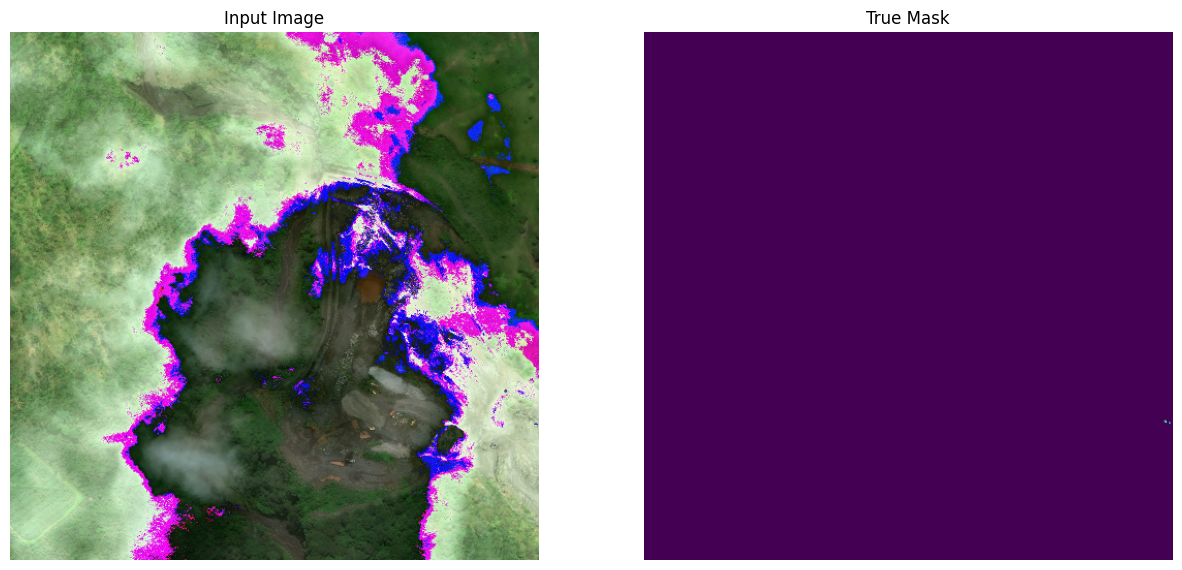

In [69]:
import matplotlib.pyplot as plt



def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ["Input Image", "True Mask", "Predicted Mask"]

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis("off")
    # Create the folder if it doesn't exist
    plt.show()


for samples in val.take(2):
    
    sample_image, sample_mask = samples["pixel_values"][0], samples["labels"][0]
    sample_image = tf.transpose(sample_image, (1, 2, 0))
    sample_mask = tf.expand_dims(sample_mask, -1)
    display([sample_image, sample_mask])

In [19]:
# this part was take from: https://keras.io/examples/vision/segformer/

from IPython.display import clear_output


def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=1)
    pred_mask = tf.expand_dims(pred_mask, -1)
    return pred_mask[0]


def show_predictions(dataset=None, num=1):
    if dataset:
        for sample in dataset.take(num):
            images, masks = sample["pixel_values"], sample["labels"]
            masks = tf.expand_dims(masks, -1)
            pred_masks = model.predict(images).logits
            images = tf.transpose(images, (0, 2, 3, 1))
            display([images[0], masks[0], create_mask(pred_masks)])
    else:
        display(
            [
                sample_image,
                sample_mask,
                create_mask(model.predict(tf.expand_dims(sample_image, 0))),
            ]
        )


class DisplayCallback(tf.keras.callbacks.Callback):
    def __init__(self, dataset, **kwargs):
        super().__init__(**kwargs)
        self.dataset = dataset

    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions(self.dataset)
        print("\nSample Prediction after epoch {}\n".format(epoch + 1))

In [ ]:
val.skip(1).take(1)

<_TakeDataset element_spec={'pixel_values': TensorSpec(shape=(None, 3, 512, 512), dtype=tf.float32, name=None), 'labels': TensorSpec(shape=(None, 512, 512), dtype=tf.float32, name=None)}>

# Train the Model

In [20]:
# running model
history = model.fit(
    train,
    validation_data=val,
    callbacks=[DisplayCallback(val)],
    epochs=10,
)


Epoch 1/10


ValueError: in user code:

    File "/Users/gmeneses/DScourse/00_capstone/xView2_baseline_fork/.venv/lib/python3.9/site-packages/keras/src/engine/training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "/Users/gmeneses/DScourse/00_capstone/xView2_baseline_fork/.venv/lib/python3.9/site-packages/keras/src/engine/training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/gmeneses/DScourse/00_capstone/xView2_baseline_fork/.venv/lib/python3.9/site-packages/keras/src/engine/training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "/Users/gmeneses/DScourse/00_capstone/xView2_baseline_fork/.venv/lib/python3.9/site-packages/transformers/modeling_tf_utils.py", line 1642, in train_step
        y_pred = self(x, training=True)
    File "/Users/gmeneses/DScourse/00_capstone/xView2_baseline_fork/.venv/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/var/folders/wg/xp3xzw0s1mb4zg1wgbnvpwn00000gn/T/__autograph_generated_filebde7uxec.py", line 37, in tf__run_call_with_unpacked_inputs
        retval_ = ag__.converted_call(ag__.ld(func), (ag__.ld(self),), dict(**ag__.ld(unpacked_inputs)), fscope)
    File "/var/folders/wg/xp3xzw0s1mb4zg1wgbnvpwn00000gn/T/__autograph_generated_fileqlrzjhh7.py", line 41, in tf__call
        outputs = ag__.converted_call(ag__.ld(self).segformer, (ag__.ld(pixel_values),), dict(output_attentions=ag__.ld(output_attentions), output_hidden_states=True, return_dict=ag__.ld(return_dict)), fscope)
    File "/var/folders/wg/xp3xzw0s1mb4zg1wgbnvpwn00000gn/T/__autograph_generated_filebde7uxec.py", line 37, in tf__run_call_with_unpacked_inputs
        retval_ = ag__.converted_call(ag__.ld(func), (ag__.ld(self),), dict(**ag__.ld(unpacked_inputs)), fscope)
    File "/var/folders/wg/xp3xzw0s1mb4zg1wgbnvpwn00000gn/T/__autograph_generated_filek207mklr.py", line 15, in tf__call
        encoder_outputs = ag__.converted_call(ag__.ld(self).encoder, (ag__.ld(pixel_values),), dict(output_attentions=ag__.ld(output_attentions), output_hidden_states=ag__.ld(output_hidden_states), return_dict=ag__.ld(return_dict), training=ag__.ld(training)), fscope)
    File "/var/folders/wg/xp3xzw0s1mb4zg1wgbnvpwn00000gn/T/__autograph_generated_filextpnbh4f.py", line 103, in tf__call
        ag__.for_stmt(ag__.converted_call(ag__.ld(enumerate), (ag__.converted_call(ag__.ld(zip), (ag__.ld(self).embeddings, ag__.ld(self).block, ag__.ld(self).layer_norms), None, fscope),), None, fscope), None, loop_body_1, get_state_4, set_state_4, ('all_hidden_states', 'all_self_attentions', 'hidden_states'), {'iterate_names': '(idx, x)'})
    File "/var/folders/wg/xp3xzw0s1mb4zg1wgbnvpwn00000gn/T/__autograph_generated_filextpnbh4f.py", line 27, in loop_body_1
        (hidden_states, height, width) = ag__.converted_call(ag__.ld(embedding_layer), (ag__.ld(hidden_states),), None, fscope)
    File "/var/folders/wg/xp3xzw0s1mb4zg1wgbnvpwn00000gn/T/__autograph_generated_file0bovj912.py", line 11, in tf__call
        embeddings = ag__.converted_call(ag__.ld(self).proj, (ag__.converted_call(ag__.ld(self).padding, (ag__.ld(pixel_values),), None, fscope),), None, fscope)

    ValueError: Exception encountered when calling layer 'tf_segformer_for_semantic_segmentation' (type TFSegformerForSemanticSegmentation).
    
    in user code:
    
        File "/Users/gmeneses/DScourse/00_capstone/xView2_baseline_fork/.venv/lib/python3.9/site-packages/transformers/modeling_tf_utils.py", line 792, in run_call_with_unpacked_inputs  *
            return func(self, **unpacked_inputs)
        File "/Users/gmeneses/DScourse/00_capstone/xView2_baseline_fork/.venv/lib/python3.9/site-packages/transformers/models/segformer/modeling_tf_segformer.py", line 819, in call  *
            outputs = self.segformer(
        File "/Users/gmeneses/DScourse/00_capstone/xView2_baseline_fork/.venv/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
        File "/var/folders/wg/xp3xzw0s1mb4zg1wgbnvpwn00000gn/T/__autograph_generated_filebde7uxec.py", line 37, in tf__run_call_with_unpacked_inputs
            retval_ = ag__.converted_call(ag__.ld(func), (ag__.ld(self),), dict(**ag__.ld(unpacked_inputs)), fscope)
        File "/var/folders/wg/xp3xzw0s1mb4zg1wgbnvpwn00000gn/T/__autograph_generated_filek207mklr.py", line 15, in tf__call
            encoder_outputs = ag__.converted_call(ag__.ld(self).encoder, (ag__.ld(pixel_values),), dict(output_attentions=ag__.ld(output_attentions), output_hidden_states=ag__.ld(output_hidden_states), return_dict=ag__.ld(return_dict), training=ag__.ld(training)), fscope)
        File "/var/folders/wg/xp3xzw0s1mb4zg1wgbnvpwn00000gn/T/__autograph_generated_filextpnbh4f.py", line 103, in tf__call
            ag__.for_stmt(ag__.converted_call(ag__.ld(enumerate), (ag__.converted_call(ag__.ld(zip), (ag__.ld(self).embeddings, ag__.ld(self).block, ag__.ld(self).layer_norms), None, fscope),), None, fscope), None, loop_body_1, get_state_4, set_state_4, ('all_hidden_states', 'all_self_attentions', 'hidden_states'), {'iterate_names': '(idx, x)'})
        File "/var/folders/wg/xp3xzw0s1mb4zg1wgbnvpwn00000gn/T/__autograph_generated_filextpnbh4f.py", line 27, in loop_body_1
            (hidden_states, height, width) = ag__.converted_call(ag__.ld(embedding_layer), (ag__.ld(hidden_states),), None, fscope)
        File "/var/folders/wg/xp3xzw0s1mb4zg1wgbnvpwn00000gn/T/__autograph_generated_file0bovj912.py", line 11, in tf__call
            embeddings = ag__.converted_call(ag__.ld(self).proj, (ag__.converted_call(ag__.ld(self).padding, (ag__.ld(pixel_values),), None, fscope),), None, fscope)
    
        ValueError: Exception encountered when calling layer 'segformer' (type TFSegformerMainLayer).
        
        in user code:
        
            File "/Users/gmeneses/DScourse/00_capstone/xView2_baseline_fork/.venv/lib/python3.9/site-packages/transformers/modeling_tf_utils.py", line 792, in run_call_with_unpacked_inputs  *
                return func(self, **unpacked_inputs)
            File "/Users/gmeneses/DScourse/00_capstone/xView2_baseline_fork/.venv/lib/python3.9/site-packages/transformers/models/segformer/modeling_tf_segformer.py", line 484, in call  *
                encoder_outputs = self.encoder(
            File "/Users/gmeneses/DScourse/00_capstone/xView2_baseline_fork/.venv/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler  **
                raise e.with_traceback(filtered_tb) from None
            File "/var/folders/wg/xp3xzw0s1mb4zg1wgbnvpwn00000gn/T/__autograph_generated_filextpnbh4f.py", line 103, in tf__call
                ag__.for_stmt(ag__.converted_call(ag__.ld(enumerate), (ag__.converted_call(ag__.ld(zip), (ag__.ld(self).embeddings, ag__.ld(self).block, ag__.ld(self).layer_norms), None, fscope),), None, fscope), None, loop_body_1, get_state_4, set_state_4, ('all_hidden_states', 'all_self_attentions', 'hidden_states'), {'iterate_names': '(idx, x)'})
            File "/var/folders/wg/xp3xzw0s1mb4zg1wgbnvpwn00000gn/T/__autograph_generated_filextpnbh4f.py", line 27, in loop_body_1
                (hidden_states, height, width) = ag__.converted_call(ag__.ld(embedding_layer), (ag__.ld(hidden_states),), None, fscope)
            File "/var/folders/wg/xp3xzw0s1mb4zg1wgbnvpwn00000gn/T/__autograph_generated_file0bovj912.py", line 11, in tf__call
                embeddings = ag__.converted_call(ag__.ld(self).proj, (ag__.converted_call(ag__.ld(self).padding, (ag__.ld(pixel_values),), None, fscope),), None, fscope)
        
            ValueError: Exception encountered when calling layer 'encoder' (type TFSegformerEncoder).
            
            in user code:
            
                File "/Users/gmeneses/DScourse/00_capstone/xView2_baseline_fork/.venv/lib/python3.9/site-packages/transformers/models/segformer/modeling_tf_segformer.py", line 419, in call  *
                    hidden_states, height, width = embedding_layer(hidden_states)
                File "/Users/gmeneses/DScourse/00_capstone/xView2_baseline_fork/.venv/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler  **
                    raise e.with_traceback(filtered_tb) from None
                File "/var/folders/wg/xp3xzw0s1mb4zg1wgbnvpwn00000gn/T/__autograph_generated_file0bovj912.py", line 11, in tf__call
                    embeddings = ag__.converted_call(ag__.ld(self).proj, (ag__.converted_call(ag__.ld(self).padding, (ag__.ld(pixel_values),), None, fscope),), None, fscope)
            
                ValueError: Exception encountered when calling layer 'patch_embeddings.0' (type TFSegformerOverlapPatchEmbeddings).
                
                in user code:
                
                    File "/Users/gmeneses/DScourse/00_capstone/xView2_baseline_fork/.venv/lib/python3.9/site-packages/transformers/models/segformer/modeling_tf_segformer.py", line 92, in call  *
                        embeddings = self.proj(self.padding(pixel_values))
                    File "/Users/gmeneses/DScourse/00_capstone/xView2_baseline_fork/.venv/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler  **
                        raise e.with_traceback(filtered_tb) from None
                    File "/Users/gmeneses/DScourse/00_capstone/xView2_baseline_fork/.venv/lib/python3.9/site-packages/keras/src/engine/input_spec.py", line 280, in assert_input_compatibility
                        raise ValueError(
                
                    ValueError: Input 0 of layer "proj" is incompatible with the layer: expected axis -1 of input shape to have value 3, but received input with shape (None, 518, 518, 6)
                
                
                Call arguments received by layer 'patch_embeddings.0' (type TFSegformerOverlapPatchEmbeddings):
                  • pixel_values=tf.Tensor(shape=(None, 512, 512, 6), dtype=float32)
            
            
            Call arguments received by layer 'encoder' (type TFSegformerEncoder):
              • pixel_values=tf.Tensor(shape=(None, 512, 512, 6), dtype=float32)
              • output_attentions=False
              • output_hidden_states=True
              • return_dict=True
              • training=True
        
        
        Call arguments received by layer 'segformer' (type TFSegformerMainLayer):
          • pixel_values=tf.Tensor(shape=(None, 6, 512, 512), dtype=float32)
          • output_attentions=False
          • output_hidden_states=True
          • return_dict=True
          • training=True
    
    
    Call arguments received by layer 'tf_segformer_for_semantic_segmentation' (type TFSegformerForSemanticSegmentation):
      • pixel_values={'pixel_values': 'tf.Tensor(shape=(None, 6, 512, 512), dtype=float32)', 'labels': 'tf.Tensor(shape=(None, 512, 512), dtype=float32)'}
      • labels=None
      • output_attentions=None
      • output_hidden_states=None
      • return_dict=None


1/1 [==============================] - 2s 2s/step


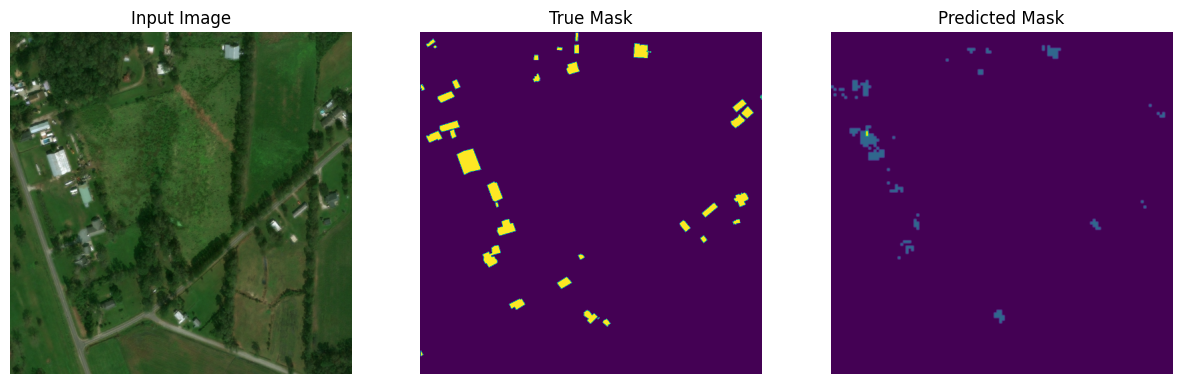

1/1 [==============================] - 2s 2s/step


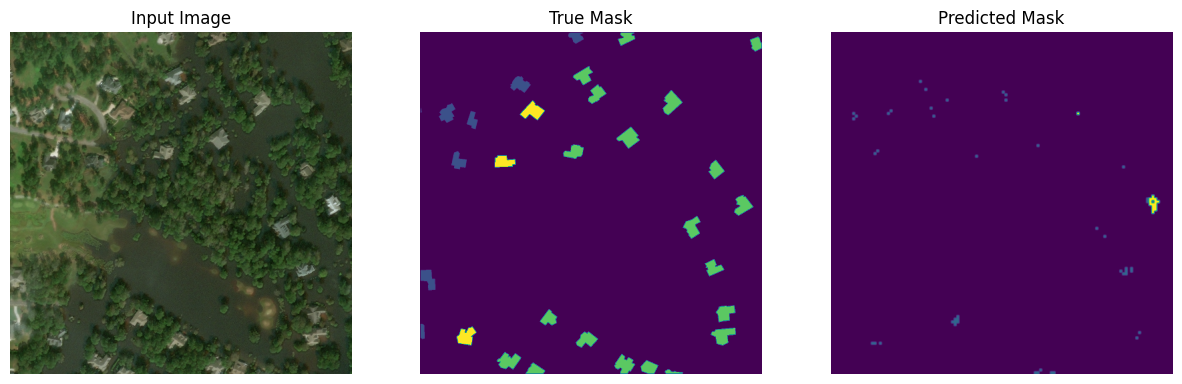

1/1 [==============================] - 2s 2s/step


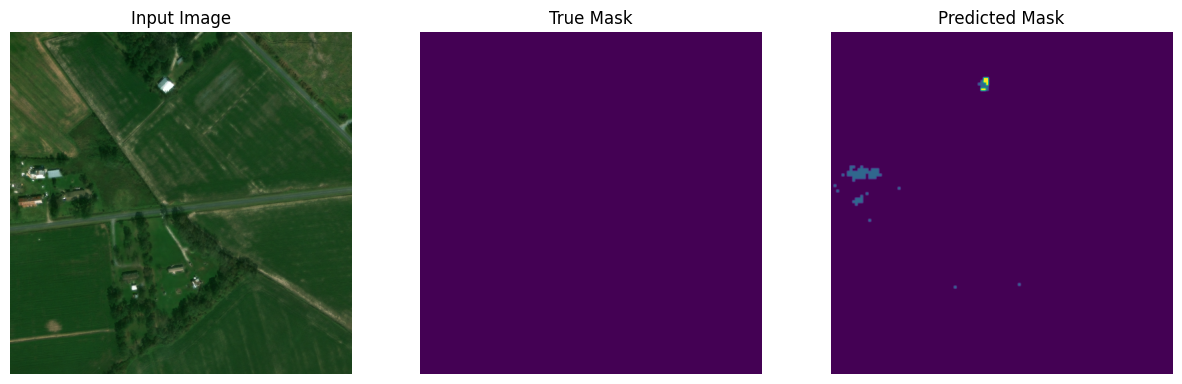

1/1 [==============================] - 2s 2s/step


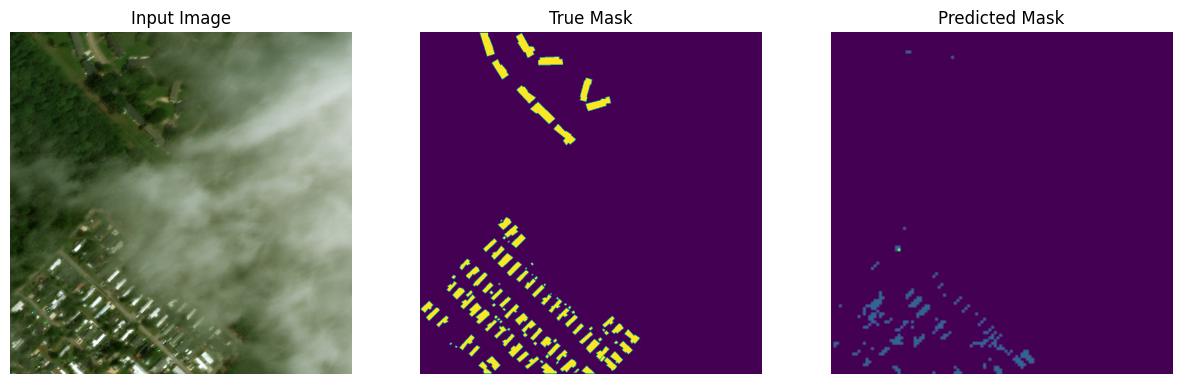

1/1 [==============================] - 2s 2s/step


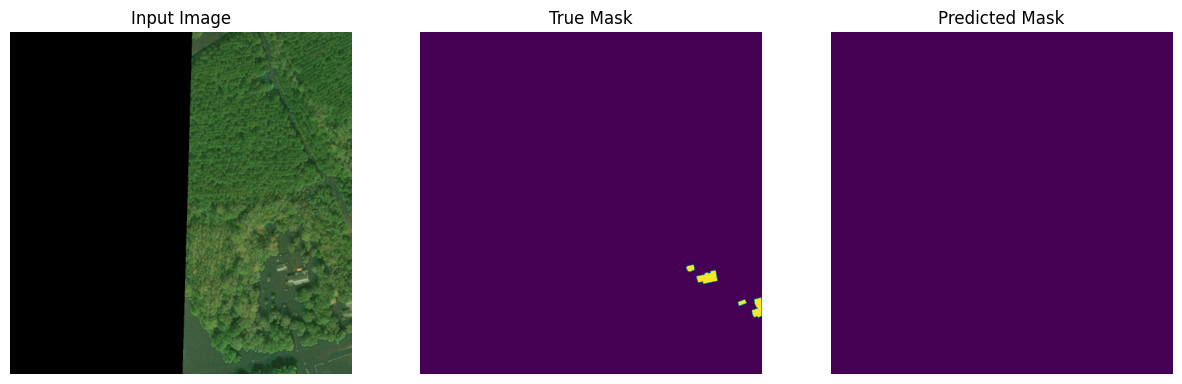

1/1 [==============================] - 2s 2s/step


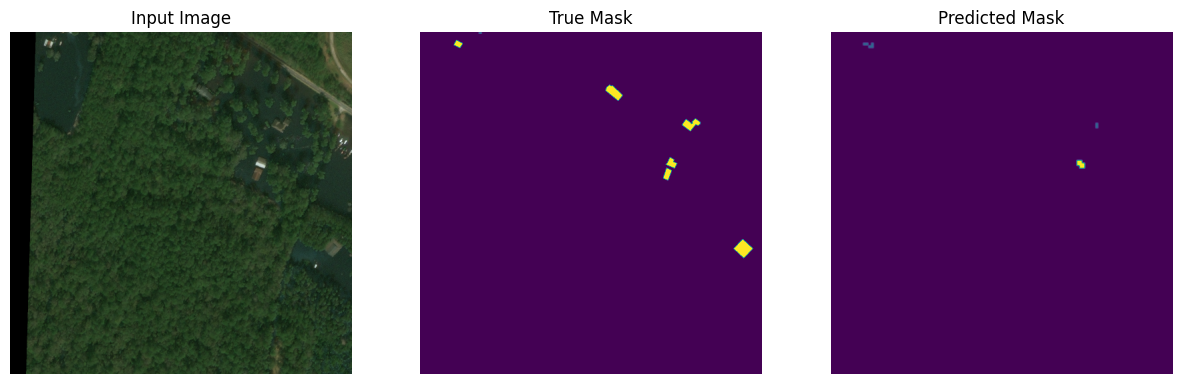

1/1 [==============================] - 2s 2s/step


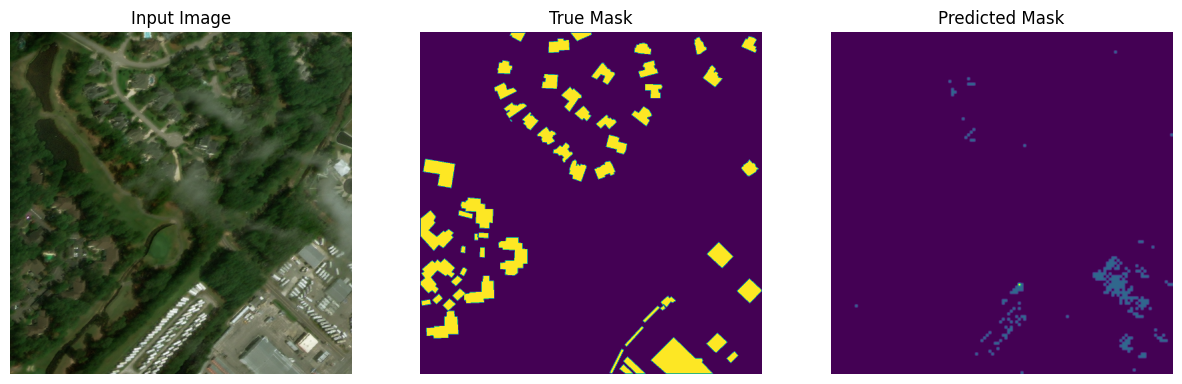

1/1 [==============================] - 2s 2s/step


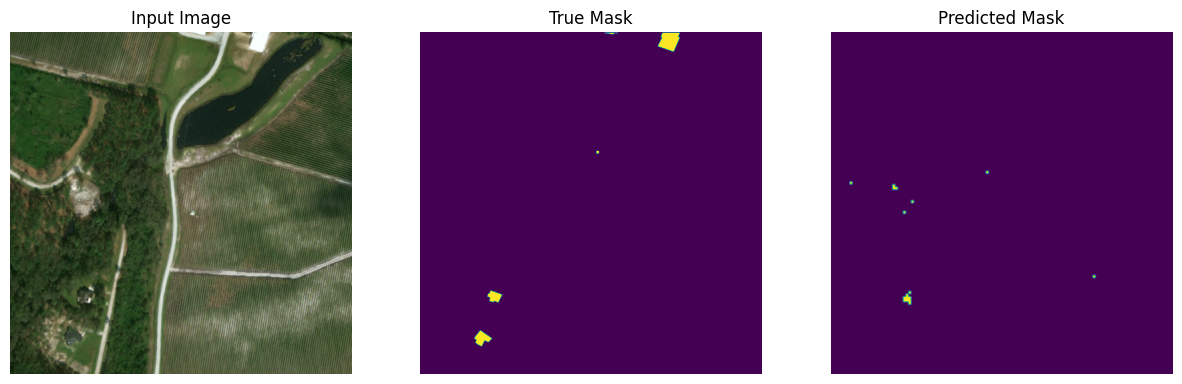

1/1 [==============================] - 2s 2s/step


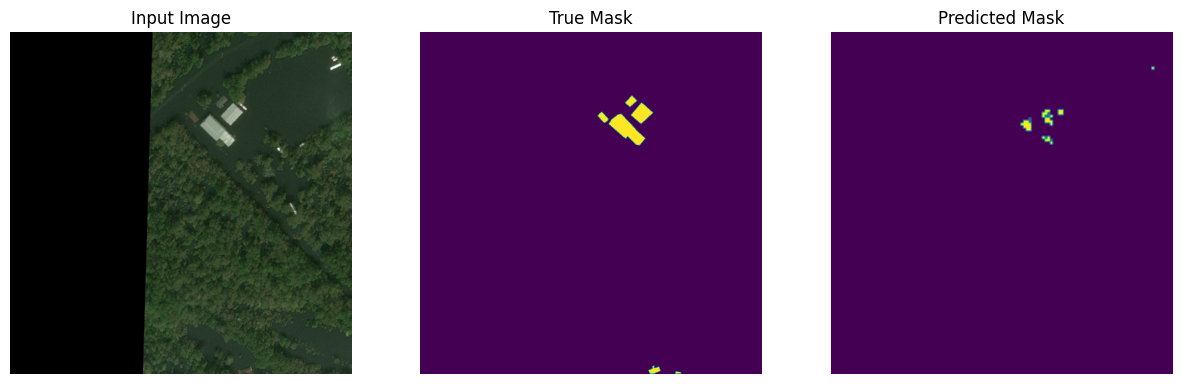

1/1 [==============================] - 2s 2s/step


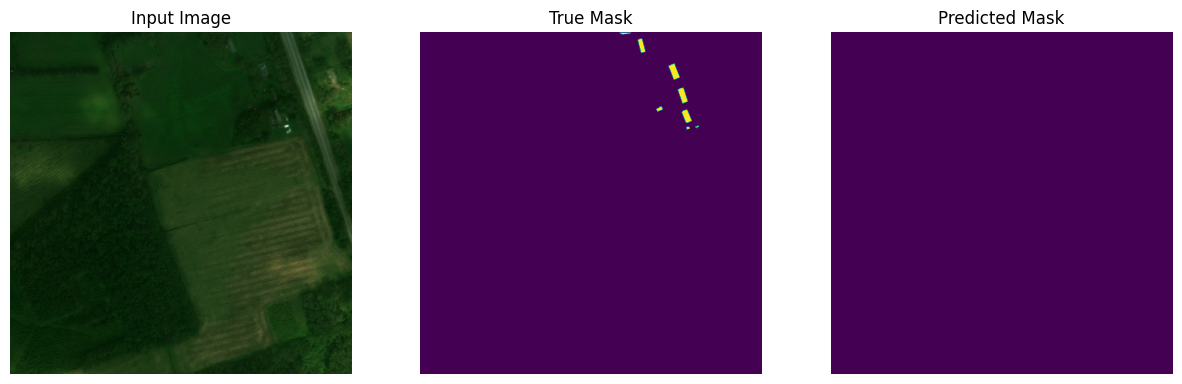

1/1 [==============================] - 1s 512ms/step


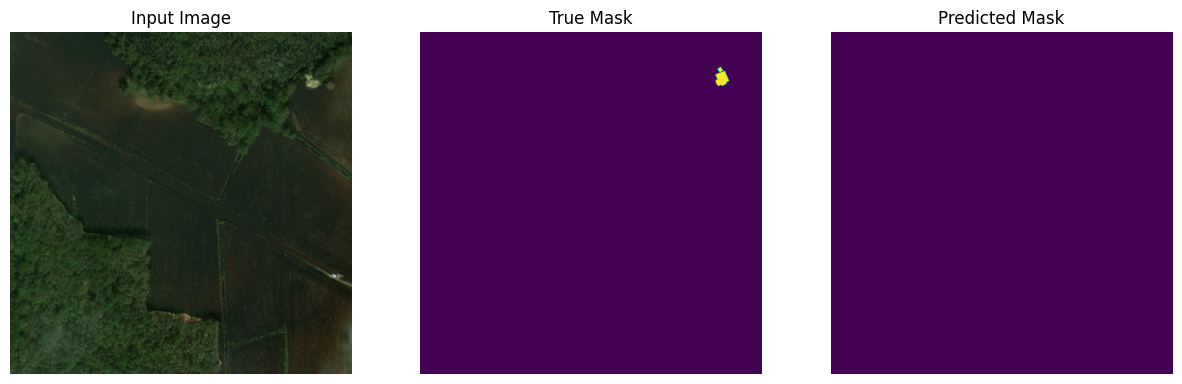

In [ ]:
#!pip install ipython
from IPython.display import clear_output
show_predictions(val, 15)

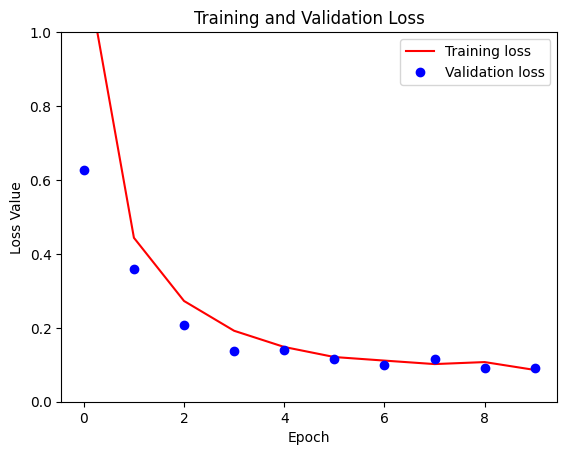

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(history.epoch, loss, 'r', label='Training loss')
plt.plot(history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()